In [1]:
#importing libraries
import pandas as pd
import gzip
import tarfile
import sqlite3
import matplotlib.pyplot as plt

# Reading data from json compressed files

In [2]:
#function to read data
def reading_data(filename):
    name = filename.split('.')[0]
    try:
        data = pd.read_json(filename,lines=True,compression='gzip')
    except:
        with gzip.open(filename, 'rb') as gz_file:
            with tarfile.open(fileobj=gz_file, mode='r:tar') as tar_file:
                for member in tar_file.getmembers():
                    if member.name.endswith('.json'):  # Check for .json files
                        with tar_file.extractfile(member) as tar_data:
                            data = pd.read_json(tar_data,lines=True)
        print(f'{name} Data was in nested compression')
    finally:
        print(f'{name} Data extracted successfully')
        print('\n')
    return data


In [3]:
brands = reading_data('brands.json.gz')
users = reading_data('users.json.gz')
receipts = reading_data('receipts.json.gz')

brands Data extracted successfully


users Data was in nested compression
users Data extracted successfully


receipts Data extracted successfully




Transformations Functions

In [4]:
#extract elememnt from dict
def transform_element(x, element):
  if isinstance(x, dict) and element in x:
    return x[element]
  else:
    return x

## Users

In [5]:
#checking users data
users.head()

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
1,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
2,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
3,{'$oid': '5ff1e1eacfcf6c399c274ae6'},True,{'$date': 1609687530554},{'$date': 1609687530597},consumer,Email,WI
4,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI


In [6]:
#extracting data from dict
users = users.applymap(lambda x :transform_element(x,'$date'))
users = users.applymap(lambda x :transform_element(x,'$oid'))

In [7]:
#dropping duplicates value
users = users.drop_duplicates()

## Brands

In [8]:
#checking brands data
brands.head()

,_id,barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,{'$oid': '601ac115be37ce2ead437551'},511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, ...",test brand @1612366101024,0.0,NaN
1,{'$oid': '601c5460be37ce2ead43755f'},511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, ...",Starbucks,0.0,STARBUCKS
2,{'$oid': '601ac142be37ce2ead43755d'},511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176
3,{'$oid': '601ac142be37ce2ead43755a'},511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051
4,{'$oid': '601ac142be37ce2ead43755e'},511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, ...",test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827


In [9]:
brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           1167 non-null   object 
 1   barcode       1167 non-null   int64  
 2   category      1012 non-null   object 
 3   categoryCode  517 non-null    object 
 4   cpg           1167 non-null   object 
 5   name          1167 non-null   object 
 6   topBrand      555 non-null    float64
 7   brandCode     933 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 73.1+ KB


In [10]:
#extracting element from dict
#crating seperated columns for cpgoid and cpgref
brands_cpg_oid = []
brands_cpg_ref = []
brands = brands.applymap(lambda x :transform_element(x,'$oid'))

for i in range(brands.shape[0]):
    brands_cpg_oid.append(brands.cpg[i]['$id']['$oid'])
    brands_cpg_ref.append(brands.cpg[i]['$ref'])

brands['cpgRef'] = brands_cpg_ref
brands['cpgOid'] = brands_cpg_oid

brands = brands.drop(['cpg'], axis = 1)

In [11]:
#new transformed dataframe
brands.head(5)

,_id,barcode,category,categoryCode,name,topBrand,brandCode,cpgRef,cpgOid
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,test brand @1612366101024,0.0,NaN,Cogs,601ac114be37ce2ead437550
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,Starbucks,0.0,STARBUCKS,Cogs,5332f5fbe4b03c9a25efd0ba
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176,Cogs,601ac142be37ce2ead437559
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051,Cogs,601ac142be37ce2ead437559
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827,Cogs,5332fa12e4b03c9a25efd1e7


## Receipts

In [12]:
#checking receipts data
receipts.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,{'$oid': '5ff1e1eb0a720f0523000575'},500.0,"Receipt number 2 completed, bonus point schedu...",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,{'$oid': '5ff1e1f10a720f052300057a'},5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},NaN,{'$date': 1609687542000},NaN,5.0,{'$date': 1609632000000},1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,{'$oid': '5ff1e1ee0a7214ada100056f'},5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,{'$oid': '5ff1e1d20a7214ada1000561'},5.0,All-receipts receipt bonus,{'$date': 1609687506000},{'$date': 1609687506000},{'$date': 1609687511000},{'$date': 1609687511000},{'$date': 1609687506000},5.0,{'$date': 1609601106000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,5ff1e194b6a9d73a3a9f1052


In [13]:
receipts.isnull().sum()

_id                          0
bonusPointsEarned          575
bonusPointsEarnedReason    575
createDate                   0
dateScanned                  0
finishedDate               551
modifyDate                   0
pointsAwardedDate          582
pointsEarned               510
purchaseDate               448
purchasedItemCount         484
rewardsReceiptItemList     440
rewardsReceiptStatus         0
totalSpent                 435
userId                       0
dtype: int64

In [14]:
#extracting element from dict
receipts = receipts.applymap(lambda x :transform_element(x,'$date'))
receipts = receipts.applymap(lambda x :transform_element(x,'$oid'))
receipts = receipts.drop(['rewardsReceiptItemList'], axis = 1)

In [15]:
#transformed dataframe
receipts.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",1609687531000,1609687531000,1.609688e+12,1609687536000,1.609688e+12,500.0,1.609632e+12,5.0,FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",1609687483000,1609687483000,1.609687e+12,1609687488000,1.609687e+12,150.0,1.609601e+12,2.0,FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,1609687537000,1609687537000,NaN,1609687542000,NaN,5.0,1.609632e+12,1.0,REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,1609687534000,1609687534000,1.609688e+12,1609687539000,1.609688e+12,5.0,1.609632e+12,4.0,FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,1609687506000,1609687506000,1.609688e+12,1609687511000,1.609688e+12,5.0,1.609601e+12,2.0,FINISHED,1.0,5ff1e194b6a9d73a3a9f1052


## RewardItemsList

In [16]:
#extracting receipts data from json source
receipts1 = reading_data('receipts.json.gz')
#extracting items from dict
receipts1 = receipts1.applymap(lambda x :transform_element(x,'$date'))
receipts1 = receipts1.applymap(lambda x :transform_element(x,'$oid'))

#checking if rewardsReceiptItemsList exist and if does, add receipt id as dict to the list of items
receipt_id_list = []
for i, data in receipts1.iterrows():
    if isinstance(data['rewardsReceiptItemList'], list):
        receipt_id = data['_id']
        #for each item in items list
        for item in data['rewardsReceiptItemList']:
            item.update({'receipt_id':receipt_id})
            receipt_id_list.append(receipt_id)


receipts Data extracted successfully




In [17]:
#creating rewards_receipt_items table by using json_normalize, explode functions on rewardsReceiptItemList column
rewards_receipt_items = pd.json_normalize(receipts1['rewardsReceiptItemList'].explode())

In [18]:
#some rows have empty values in barcode column but for that rows brandCode column is not null
#the business questions require answers related to brands i.e. brandCode
#In such scenario, null brandCode values cannot be ignored and ideally the barcode should not be null but there are
#For time-being, assigning 404 value to empty barcode (Root problem is data quality, to be solved later on)
rewards_receipt_items['barcode'] = rewards_receipt_items['barcode'].fillna(404)
#creating a new column which will be used as primary key
rewards_receipt_items['receiptBarcodeRow'] = (rewards_receipt_items['receipt_id'].astype(str) + rewards_receipt_items['barcode'].astype(str) + (rewards_receipt_items.index + 1).astype(str))

In [19]:
#transformed dataframe
rewards_receipt_items.head()

,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,userFlaggedNewItem,...,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId,receiptBarcodeRow
0,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5ff1e1eb0a720f052300057540111
1,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5ff1e1bb0a720f052300056b40112
2,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,True,2,True,1.0,028400642255,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5ff1e1bb0a720f052300056b0284006422553
3,404,NaN,NaN,NaN,False,1,True,NaN,4011,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5ff1e1f10a720f052300057a4044
4,4011,ITEM NOT FOUND,28.00,28.00,False,1,True,4.0,4011,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5ff1e1ee0a7214ada100056f40115


## Fact Items

In [20]:
#Creating fact table of userid, receipt_id, barcode, brandcode
receipt_user = receipts.merge(users, left_on='userId', right_on='_id')
fact = receipt_user.merge(rewards_receipt_items,left_on = '_id_x', right_on = 'receipt_id')
fact = fact[['receiptBarcodeRow', 'receipt_id','userId','brandCode']]
fact = fact.dropna()

In [21]:
fact.head()

,receiptBarcodeRow,receipt_id,userId,brandCode
12,5ff1e1cd0a720f052300056f4049,5ff1e1cd0a720f052300056f,5ff1e194b6a9d73a3a9f1052,MISSION
13,5ff1e1a40a720f052300056904600083251710,5ff1e1a40a720f0523000569,5ff1e194b6a9d73a3a9f1052,BRAND
196,5ff29be20a7214ada1000571044000000745151,5ff29be20a7214ada1000571,5964eb07e4b03efd0c0f267b,KRAFT EASY CHEESE
317,5ff618e30a7214ada10005fa012000809941309,5ff618e30a7214ada10005fa,5ff616a68f142f11dd189163,PEPSI
319,5ff618e30a7214ada10005fa028400642033311,5ff618e30a7214ada10005fa,5ff616a68f142f11dd189163,DORITOS


#### Renaming and arranging Columns

In [22]:
#Brands
brands = brands.rename(columns={"_id": "brand_id"})
brands_column_to_move = brands.pop("brandCode")
brands.insert(0, "brandCode", brands_column_to_move)

#Users
users = users.rename(columns={"_id": "user_id"})

#fact
fact = fact.rename(columns={"userId": "user_id"})

#Receipts
receipts = receipts.rename(columns={"_id": "receipt_id"})

#rewards_receipt_items
column_to_move = rewards_receipt_items.pop("receiptBarcodeRow")
column_to_move1 = rewards_receipt_items.pop("receipt_id")

rewards_receipt_items.insert(0, "receiptBarcodeRow", column_to_move)
rewards_receipt_items.insert(1, "receipt_id", column_to_move1)

## Creating databases

Using get_schema to generate DDL query

In [23]:
fact_ddl = pd.io.sql.get_schema(fact, 'data')
print(fact_ddl)

CREATE TABLE "data" (
"receiptBarcodeRow" TEXT,
  "receipt_id" TEXT,
  "user_id" TEXT,
  "brandCode" TEXT
)


## Database and Table creation

In [24]:
conn = sqlite3.connect('fetch.db') 
c = conn.cursor()

#Creating Users Table
c.execute('''
          CREATE TABLE IF NOT EXISTS users
          (user_id TEXT PRIMARY KEY,
            active BOOLEAN,
            createdDate TEXT,
            lastLogin TEXT,
            role TEXT,
            signUpSource TEXT,
            state TEXT)
          ''')

#creating Brands Table    
c.execute('''
          CREATE TABLE IF NOT EXISTS brands 
          ("brandCode" TEXT PRIMARY KEY,
            "brand_id" TEXT,
            "barcode" INTEGER,
            "category" TEXT,
            "categoryCode" TEXT,
            "name" TEXT,
            "topBrand" BOOLEAN,
            "cpgRef" TEXT,
            "cpgOid" TEXT)
          ''')

#creating Receipts Table    
c.execute('''
          CREATE TABLE IF NOT EXISTS receipts
          ("receipt_id" TEXT PRIMARY KEY,
            "bonusPointsEarned" REAL,
            "bonusPointsEarnedReason" TEXT,
            "createDate" INTEGER,
            "dateScanned" INTEGER,
            "finishedDate" INTEGER,
            "modifyDate" INTEGER,
            "pointsAwardedDate" INTEGER,
            "pointsEarned" REAL,
            "purchaseDate" INTEGER,
            "purchasedItemCount" INTEGER,
            "rewardsReceiptStatus" TEXT,
            "totalSpent" REAL,
            "userId" TEXT)
          ''')

#creating Rewards Items Table    
c.execute('''
          CREATE TABLE IF NOT EXISTS rewardsItemsList 
          ("receiptBarcodeRow" INTEGER PRIMARY KEY,
            "receipt_id" TEXT,
            "barcode" INTEGER,
            "description" TEXT,
            "finalPrice" TEXT,
            "itemPrice" TEXT,
            "needsFetchReview" BOOLEAN,
            "partnerItemId" TEXT,
            "preventTargetGapPoints" INTEGER,
            "quantityPurchased" REAL,
            "userFlaggedBarcode" INTEGER,
            "userFlaggedNewItem" INTEGER,
            "userFlaggedPrice" REAL,
            "userFlaggedQuantity" INTEGER,
            "needsFetchReviewReason" TEXT,
            "pointsNotAwardedReason" TEXT,
            "pointsPayerId" TEXT,
            "rewardsGroup" TEXT,
            "rewardsProductPartnerId" TEXT,
            "userFlaggedDescription" TEXT,
            "originalMetaBriteBarcode" TEXT,
            "originalMetaBriteDescription" TEXT,
            "brandCode" TEXT,
            "competitorRewardsGroup" TEXT,
            "discountedItemPrice" TEXT,
            "originalReceiptItemText" TEXT,
            "itemNumber" TEXT,
            "originalMetaBriteQuantityPurchased" REAL,
            "pointsEarned" TEXT,
            "targetPrice" TEXT,
            "competitiveProduct" INTEGER,
            "originalFinalPrice" TEXT,
            "originalMetaBriteItemPrice" TEXT,
            "deleted" INTEGER,
            "priceAfterCoupon" TEXT,
            "metabriteCampaignId" TEXT)
          ''')

#Creating Fact Table
c.execute('''
          CREATE TABLE IF NOT EXISTS fact
          ("receiptBarcodeRow" INTEGER PRIMARY KEY,
            "receipt_id" TEXT,
            "user_id" TEXT,
            "brandCode" TEXT)
          ''')
                     
conn.commit()
conn.close()

### Pushing pandas dataframe into tables

In [25]:
conn = sqlite3.connect("fetch.db")

##push the dataframe to sql 
users.to_sql("users", conn, if_exists="replace",index = False)
brands.to_sql("brands", conn, if_exists="replace",index = False)
receipts.to_sql("receipts", conn, if_exists="replace",index = False)
rewards_receipt_items.to_sql("rewardsItemsList", conn, if_exists="replace",index = False)
fact.to_sql("fact", conn, if_exists="replace",index = False)

conn.commit()
conn.close()


## SQL Queries for business stakeholder quesstions

### Quesiton 1 : What are the top 5 brands by receipts scanned for most recent month?

In [26]:
conn = sqlite3.connect("fetch.db")
c = conn.cursor()

c.execute('''
    with receipt_month as (
          select receipt_id, strftime('%m',(Date(ROUND(receipts.dateScanned / 1000), 'unixepoch'))) as month
          from receipts
    )
    select brandCode,count(brandCode) as total_receipts_scanned
    from fact
    join receipt_month
    on fact.receipt_id = receipt_month.receipt_id
    where receipt_month.month = '03'
    group by brandCode
    order by count(brandCode)
''')
for row in c.fetchall():
    print(row)

conn.commit()
conn.close()


For the most recent month of receipts table the brandCode is null. A data quality issue

### Question 2: How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?

In [27]:
conn = sqlite3.connect("fetch.db")
c = conn.cursor()

c.execute('''
    with receipt_month as (
          select receipt_id, strftime('%m',(Date(ROUND(receipts.dateScanned / 1000), 'unixepoch'))) as month
          from receipts
    ), 
    month_3 as (
        select brandCode, rank() over (order by count(brandCode) desc) as brand_ranking
        from fact
        join receipt_month
        on fact.receipt_id = receipt_month.receipt_id
        where receipt_month.month = '03'
        group by brandCode
        ),
    month_2 as (
        select brandCode, rank() over (order by count(brandCode) desc) as brand_ranking
        from fact
        join receipt_month
        on fact.receipt_id = receipt_month.receipt_id
        where receipt_month.month = '02'
        group by brandCode
        )
    select month_2.brandCode, month_2.brand_ranking, month_3.brand_ranking, (month_2.brand_ranking - month_3.brand_ranking) as rank_change
    from month_3
    join month_2
    on month_3.brandCode = month_2.brandCode;
    
''')
for row in c.fetchall():
    print(row)

conn.commit()
conn.close()


### Question 3 : When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

Assumption - 'rewardsReceiptStatus' doesn't have 'Accepted' flag, so considering 'Finished' flag as 'Accepted'

In [28]:
conn = sqlite3.connect("fetch.db")
c = conn.cursor()

c.execute('''
    select rewardsReceiptStatus, avg(totalSpent)
    from receipts
    where rewardsReceiptStatus = 'FINISHED' or rewardsReceiptStatus = 'REJECTED'
    group by rewardsReceiptStatus
''')
for row in c.fetchall():
    print(row)

conn.commit()
conn.close()


('FINISHED', 80.85430501930502)
('REJECTED', 23.326056338028184)


The average spend from receipts with 'rewardsReceiptStatus’ of 'Accepted’ is greater.

### Question 4 - When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

Assumption - 'rewardsReceiptStatus' doesn't have 'Accepted' flag, so considering 'Finished' flag as 'Accepted'

In [29]:
conn = sqlite3.connect("fetch.db")
c = conn.cursor()

c.execute('''
    select rewardsReceiptStatus, sum(purchasedItemCount)
    from receipts
    where rewardsReceiptStatus = 'FINISHED' or rewardsReceiptStatus = 'REJECTED'
    group by rewardsReceiptStatus
''')
for row in c.fetchall():
    print(row)

conn.commit()
conn.close()


('FINISHED', 8184.0)
('REJECTED', 173.0)


The total number of items purchased with 'rewardsReceiptStatus’ of 'Accepted’ is greater.

### Quesiton 5 - Which brand has the most spend among users who were created within the past 6 months?

In [30]:
conn = sqlite3.connect("fetch.db")
c = conn.cursor()

c.execute('''
    with latest_user_creation_date as (
        select max(Date(ROUND(createdDate / 1000), 'unixepoch')) as latest_date
        from users
    ),
    user_created_past_6_months as (
          select user_id
          from users
          where Date(ROUND(createdDate / 1000), 'unixepoch') > DATE((select latest_date from latest_user_creation_date),'-6 month')
    )
    select fact.brandCode, round(sum(receipts.totalSpent),2) as totalSpend
    from user_created_past_6_months
    join fact
    on fact.user_id = user_created_past_6_months.user_id
    join receipts
    on fact.receipt_id = receipts.receipt_id
    group by fact.brandCode
    order by totalSpend desc limit 1
''')
for row in c.fetchall():
    print(row)

conn.commit()
conn.close()


('BEN AND JERRYS', 197337.68)


"Ben And Jerrys" brands has the most spend among users who were created within past 6 months

Question 6 : Which brand has the most transactions among users who were created within the past 6 months?

In [31]:
conn = sqlite3.connect("fetch.db")
c = conn.cursor()

c.execute('''
    select brandCode, count(receipt_id) as transactions
    from fact
    group by brandCode
    order by transactions desc limit 1
''')
for row in c.fetchall():
    print(row)

conn.commit()
conn.close()


('HY-VEE', 291)


"HY-VEE" brand has the most trannsactions among users who were created within past 6 months

## Data Qaulity

In [32]:
def grouped_bar_chart_missing_unique(df):

  # Calculate missing and unique value percentages
  missing_percentages = (df.isna().sum() / df.shape[0]) * 100
  unique_percentages = (df.nunique() / df.shape[0]) * 100

  # Create the grouped bar chart
  n_cols = len(df.columns)
  x = list(range(n_cols))
  width = 0.4

  fig, ax = plt.subplots(figsize=(18, 10))

  rects1 = ax.bar([pos - width/2 for pos in x], missing_percentages, width, label='Missing', color='red')
  rects2 = ax.bar([pos + width/2 for pos in x], unique_percentages, width, label='Unique', color='blue')
  for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}%', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', color='black')

  for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}%', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', color='black')

  # Add labels, title, and legend
  ax.set_xticks(x)
  ax.set_xticklabels(df.columns, rotation=45)
  ax.set_ylabel('Percentage (%)')
  ax.set_title('Missing and Unique Values in Each Column')
  ax.legend()

  # Customize layout
  plt.tight_layout()
  plt.show()

def duplicate_percentage(df,text):
  x = round(((len(df)-len(df.drop_duplicates())) / len(df)) * 100,2)
  print (f'{text} table has {x}% duplicate rows')

def check_values_exist(df1,df2, df1column, df2column):
    """
    Check if all values of column1 exist in column2 of a DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame to analyze.
    column1 (str): The name of the first column.
    column2 (str): The name of the second column.

    Returns:
    tuple: A tuple containing a boolean indicating whether all values of column1 exist in column2,
           and the percentage of values from column1 present in column2.
    """
    # Get unique values of both columns
    values_column1 = df1[df1column].unique()
    values_column2 = df2[df2column].unique()

    # Count the number of values from column1 present in column2
    count_values_present = sum(1 for value in values_column1 if value in values_column2)

    # Calculate the percentage of values from column1 present in column2
    percentage_values_present = round((count_values_present / len(values_column1)) * 100,2)

    # Check if all values of column1 exist in column2
    all_values_exist = count_values_present == len(values_column1)

    if all_values_exist:
      print('All values present')
    else:
      print(f'{100 - percentage_values_present}% values missing')

    return all_values_exist, percentage_values_present


Users

users Data was in nested compression
users Data extracted successfully


users table has 57.17% duplicate rows


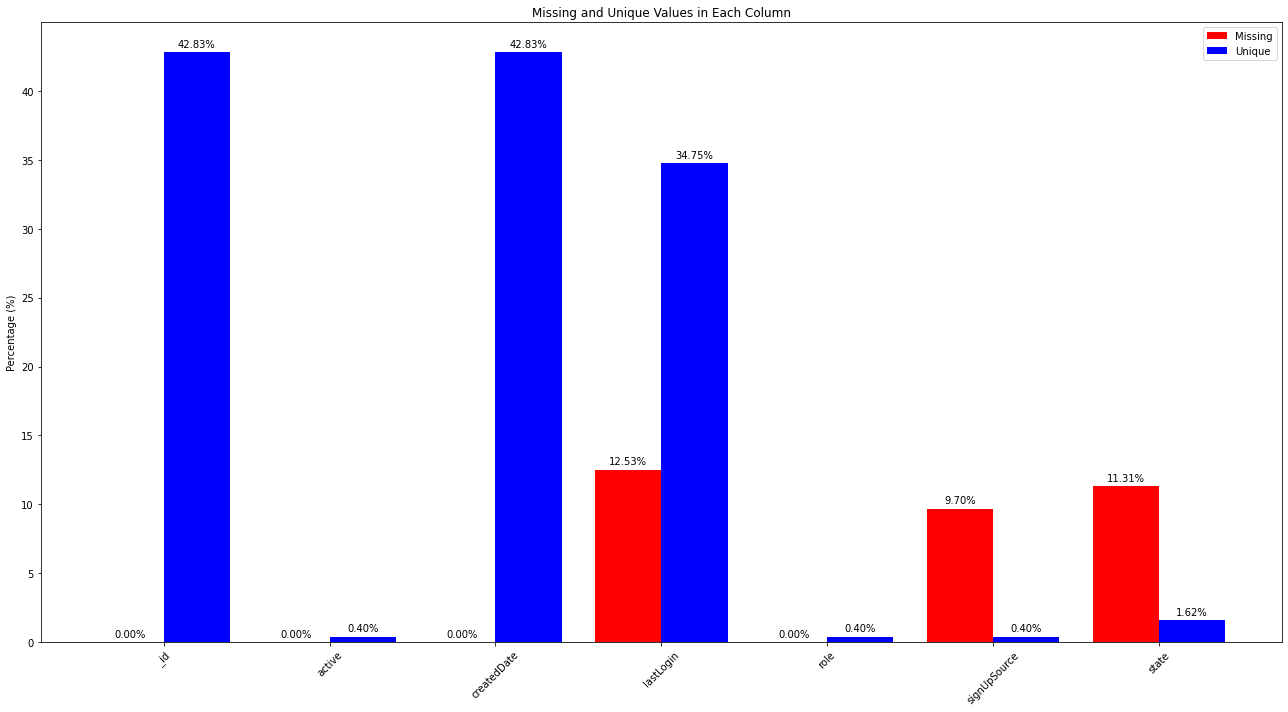

In [33]:
users = reading_data('users.json.gz')
users = users.applymap(lambda x :transform_element(x,'$date'))
users = users.applymap(lambda x :transform_element(x,'$oid'))
duplicate_percentage(users,'users')
grouped_bar_chart_missing_unique(users)

Receipts

receipts table has 0.0% duplicate rows


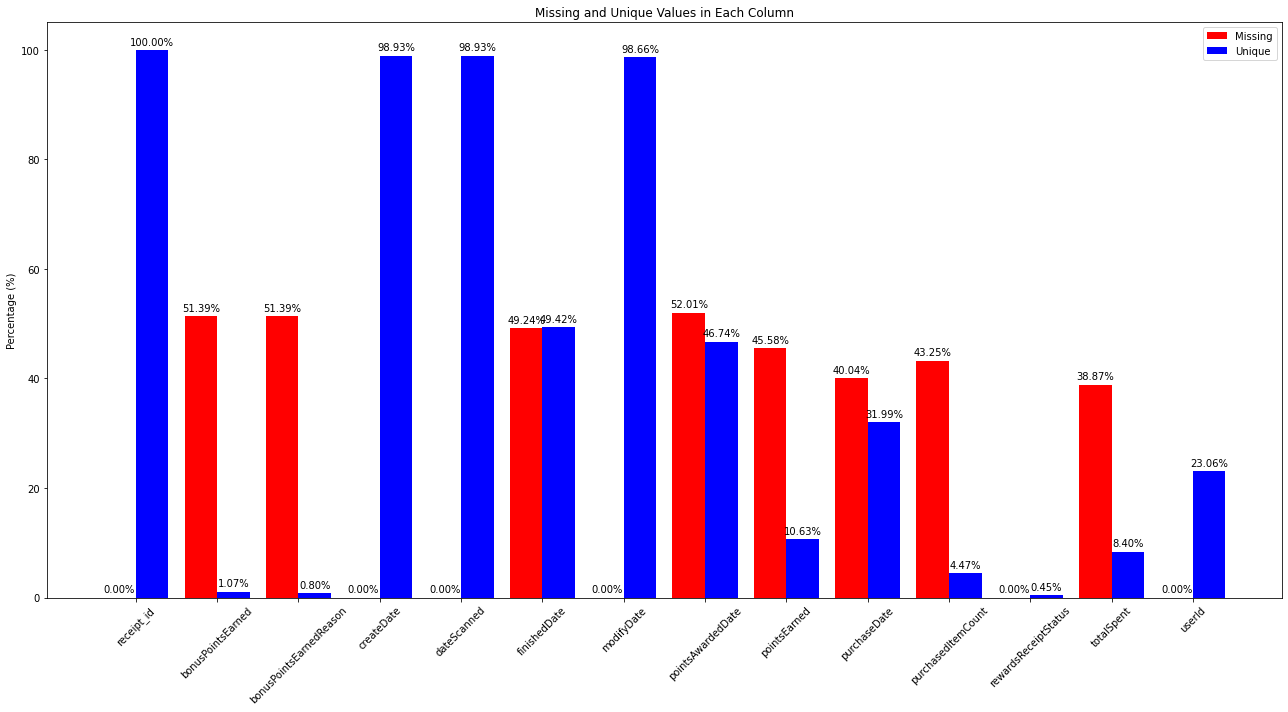

In [34]:
duplicate_percentage(receipts,'receipts')
grouped_bar_chart_missing_unique(receipts)

Brands

brands table has 0.0% duplicate rows


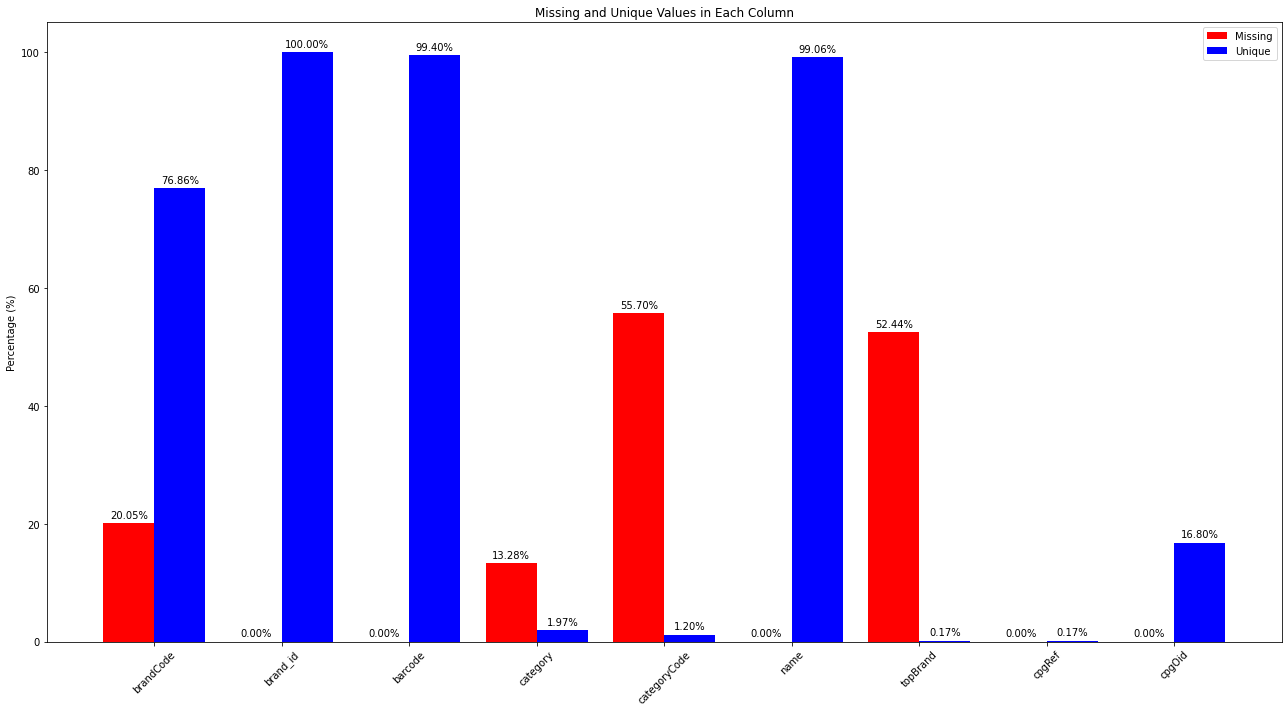

In [35]:
duplicate_percentage(brands,'brands')
grouped_bar_chart_missing_unique(brands)

rewardsReceiptItems

rewards_receipt_items table has 0.0% duplicate rows


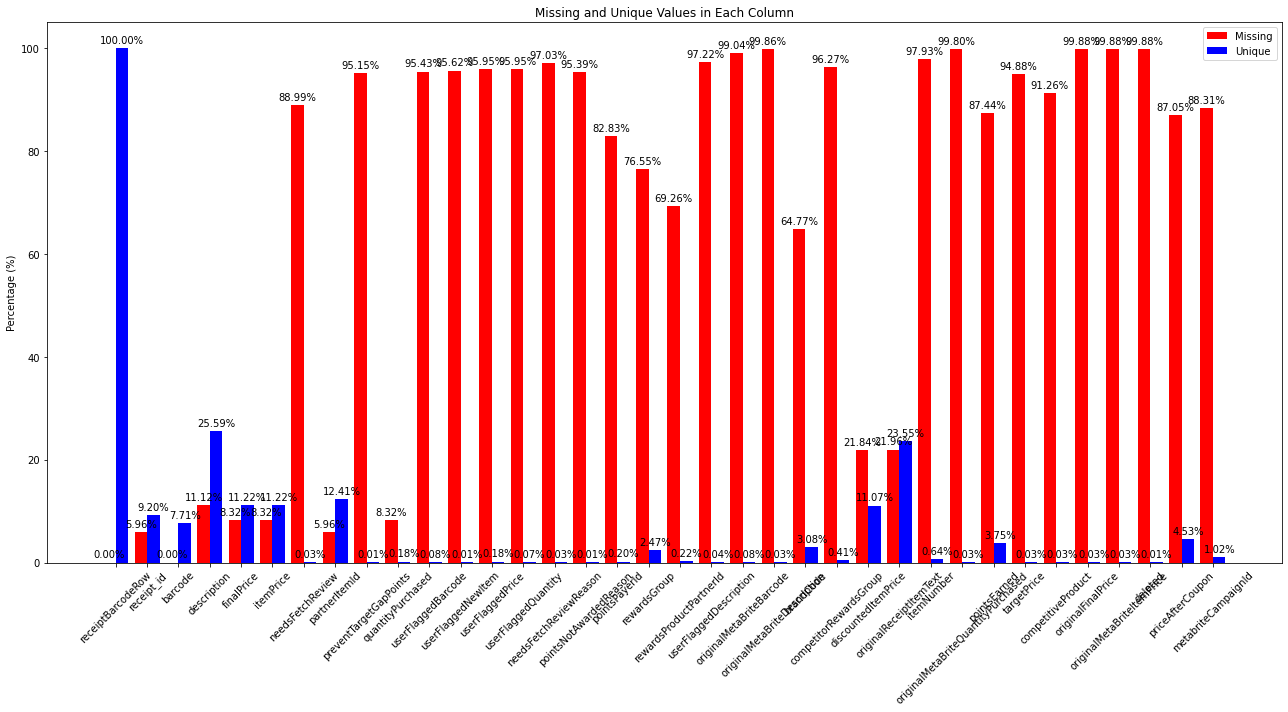

In [36]:
duplicate_percentage(rewards_receipt_items,'rewards_receipt_items')
grouped_bar_chart_missing_unique(rewards_receipt_items)

Checking if foreign key violation / non existent references

In [37]:
all_values_exist, percentage_values_present = check_values_exist(receipts,users,df1column = 'userId', df2column = '_id')
all_values_exist, percentage_values_present = check_values_exist(rewards_receipt_items,brands,df1column = 'brandCode', df2column = 'brandCode')
all_values_exist, percentage_values_present = check_values_exist(rewards_receipt_items,brands,df1column = 'barcode', df2column = 'barcode')

45.35% values missing
82.02% values missing
100.0% values missing


/tmp/ipykernel_804192/3862894477.py:59: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  count_values_present = sum(1 for value in values_column1 if value in values_column2)


# Data Quality Insights

1.   **Nested Compression**:\
Users json file was in nested compression. For time being, it's handled using code but further inconsistent different nested compression will be an issue.

2.   **Missing Values**:\
Users Table - 9.7% signUpSource, 11.3% state and 12.5 % lastLogin values are missing.\
Receipts Table - Missing values for multiple columns ranging from 39% to 52%.\
Brands Table - Missing values for columns range from 13% to 55%. Especially brandCode and categoryCode are important but have large missing values.\
rewardsReceipItmes - This table has the most missing values where almost all columns have missing values ranging from 22% to 98%. (majorly range is around 90%)

3. **Duplicates**:\
Users table has 57% duplicate rows which is a big issue.

4. **Foreign Key violations/non existent reference**: \
45% of userId in receipts table are non-existent users from Users Table.\
Meaning that either the Users table database is incomplete/inconsistent or receipts data source is taking garbage values.\
Same is the case for -\
**rewardsReceiptItems brandCode** - 82% of values don't exist in Brands brandCode\
**rewardsReceiptItems barcode** -100% of values don't exist in Brands barcode

### Data Quality Recommendations

1.   **Data QC and validation at source**:\
Apply quality checks and data validation at data source to avoid data quality cascade issues further down the line

2.   **Data Quality Awareness for Partners**:\
Provide data awareness and data ingestion suggestions to partners to improve the data ingestion methods and enhance quality.

3. **SME Collaboration**:\
Working with SME would help to better understand the data and help learn their expectations to address needs effectively.